In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import numpy as np

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, LeakyReLU, RNN
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [3]:
df = pd.read_csv('INFY.csv')

In [4]:
df_close = df.reset_index()['Close']
df_close.tail()

5301    1343.55
5302    1348.50
5303    1356.00
5304    1356.35
5305    1354.35
Name: Close, dtype: float64

In [5]:
# df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
# df

In [6]:
scaler = sklearn.preprocessing.StandardScaler()
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [7]:
train_size = int(len(df_close)*0.80)
test_size = len(df_close) - train_size
train_data = df_close[0:train_size,:]
test_data = df_close[train_size:,:]

In [8]:
print(test_data)

[[-0.89760832]
 [-0.90886974]
 [-0.90900946]
 ...
 [-0.68512228]
 [-0.68492667]
 [-0.68604443]]


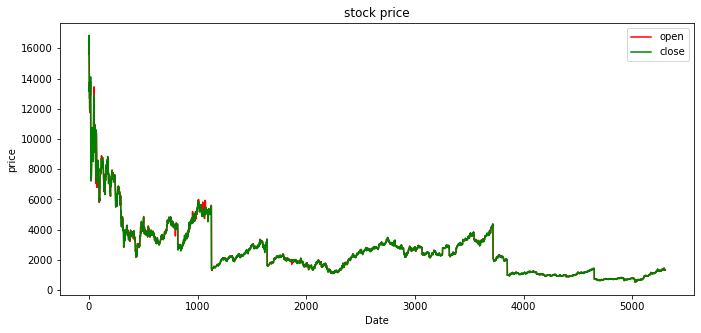

In [9]:
plt.figure(figsize=(25, 5));
plt.subplot(1,2,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
# plt.plot(df.Low.values, color='blue', label='low')
# plt.plot(df.High.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('Date')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()


In [10]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].values.reshape(-1,1))
    return df

norm_df = normalize_data(df)

In [11]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        dataX.append(dataset[i:(i+time_step),0])
        dataY.append(dataset[(i+time_step),0])
    
    return np.array(dataX), np.array(dataY)

In [12]:
# def create_dataset(dataset, time_step):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-time_step-1):
#         dataX.append(dataset.iloc[i:(i+time_step),1:])
#         dataY.append(dataset.iloc[(i+time_step),1:])
    
#     return np.array(dataX), np.array(dataY)

In [23]:
time_step = 100
train_x, train_y = create_dataset(train_data, time_step)
test_x, test_y = create_dataset(test_data, time_step)
test_x.shape, test_y.shape

((961, 100), (961,))

In [14]:
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],1)
test_x = test_x.reshape(test_x.shape[0],test_x.shape[1],1)

In [15]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape


((4143, 100, 1), (4143,), (961, 100, 1), (961,))

In [16]:

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
# for i in range(n_layers):
#     model.add(LSTM(128,
#                     input_shape=(120,4),
#                     return_sequences=True,
#                     ))
#     model.add(LeakyReLU(alpha=0.3))
# #     model.add(Reshape([-1, n_neurons]))
#     model.add(Dense(4))
# #     model.add(Reshape((-1, n_steps, n_outputs)))
model.compile(loss='mean_squared_error', optimizer='adam',metrics = [tf.keras.metrics.Accuracy()] )


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=6, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)

tb = TensorBoard('logs')

history = model.fit(train_x, train_y, 
                          validation_data=(test_x, test_y), 
                          epochs=100, batch_size=64, shuffle=False, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1)

Epoch 1/100
52/52 [==============================] - 33s 430ms/step - loss: 1.5627 - accuracy: 0.0000e+00 - val_loss: 0.0271 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.02714, saving model to model.h5
Epoch 2/100
52/52 [==============================] - 11s 209ms/step - loss: 0.4085 - accuracy: 0.0000e+00 - val_loss: 0.0355 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.02714
Epoch 3/100
52/52 [==============================] - 12s 222ms/step - loss: 0.1603 - accuracy: 0.0000e+00 - val_loss: 0.0507 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.02714
Epoch 4/100
52/52 [==============================] - 11s 210ms/step - loss: 0.2117 - accuracy: 0.0000e+00 - val_loss: 0.0943 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.02714
Epoch 5/100
52/52 [==============================] - 11s 216ms/step - loss: 0.4273 - accuracy: 0.0000e+00 - val_loss: 0.1314 - val_accuracy: 0.0000e+00

Epoch

In [19]:
model = tf.keras.models.load_model(r'C:\Users\prana\Desktop\model.h5')

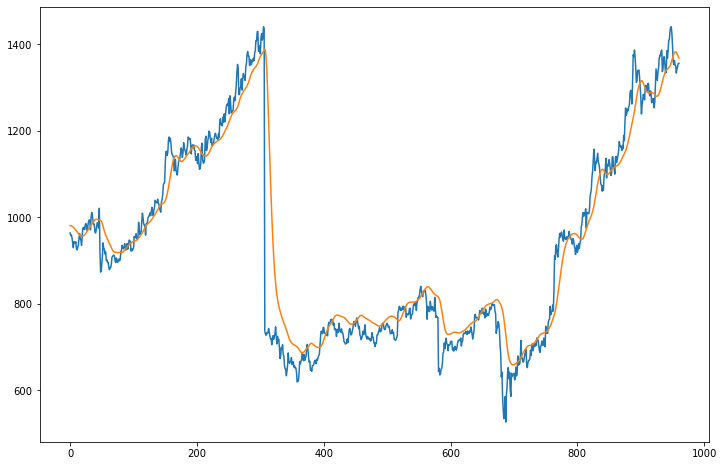

In [20]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step,:] = train_predict

testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (time_step*2) +1:len(df_close)-1, :] = test_predict

plt.figure(figsize=[12,8])
#plt.plot(scaler.inverse_transform(df_close))
plt.plot(scaler.inverse_transform(test_y), label ='actual')
#plt.plot(scaler.inverse_transform(trainPredictPlot))
plt.plot(scaler.inverse_transform(test_predict), label = 'Predicted')
plt.show()



In [22]:
sns.kdeplot(y_test, shade=True)
sns.kdeplot(y_pred, shade=True)

NameError: name 'y_test' is not defined

In [26]:
from sklearn.metrics import mean_squared_error
import math
print(1 - mean_squared_error(test_y, test_predict))

0.9982330415144166


In [29]:
x = scaler.inverse_transform(test_y)
y = scaler.inverse_transform(test_predict)
x[-1],y[-1]

(1356.35, array([1368.8646], dtype=float32))

In [25]:
plt.savefig('plot.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [33]:
# parameters 
n_inputs = 4
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 10
n_epochs = 100 

In [ ]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]


In [ ]:
# parameters
n_steps = seq_len-1 
n_inputs = 4
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 10
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

In [ ]:
x_test.shape[1:]

In [ ]:
n_steps

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, StackedRNNCells, Reshape, LeakyReLU, RNN
from tensorflow.keras.optimizers import Adam

In [ ]:

model = Sequential()
for i in range(n_layers):
    model.add(LSTM(128,
                    input_shape=(100,1),
                    return_sequences=True,
                    ))
    model.add(LeakyReLU(alpha=0.3))
#     model.add(Reshape([-1, n_neurons]))
    model.add(Dense(n_outputs))
#     model.add(Reshape((-1, n_steps, n_outputs)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, batch_size=4,epochs=100, verbose=1, shuffle=False)

In [ ]:
layers = []
for i in range(n_layer):
    layers.append(LSTM(128,
                    input_shape=(x_train.shape[1],1),
                    activation='leaky_relu',
                    return_sequences=True,
                    use_peepholes=True
                    ))
multi_layer_cell = StackedRNNCells(layers)

rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, x_train, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 

stacked_outputs = Dense(stacked_rnn_outputs, n_outputs)

outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = Adam(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

# with tf.Session() as sess: 
#     sess.run(tf.global_variables_initializer())
#     print (int(n_epochs*train_set_size/batch_size))
for iteration in range(int(n_epochs*train_set_size/batch_size)):
    x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
    sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
    if iteration % int(5*train_set_size/batch_size) == 0:
        mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
        mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
        print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
            iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

In [ ]:

X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

#use LSTM Cell with peephole connections
layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=n_neurons, 
                                 activation=tf.nn.leaky_relu, use_peepholes = True)
         for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.keras.layers.Dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    print (int(n_epochs*train_set_size/batch_size))
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})